In [1]:
!pip install statsmodels=='0.13.2'
!pip install pmdarima

     |████████████████████████████████| 9.8 MB 4.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 1.4 MB 3.8 MB/s 


In [2]:
import statsmodels as sts
sts.__version__

'0.13.2'

### **Fontes de pesquisa:**
> **Google acadêmico**
- Bitcoin Price Prediction: An ARIMA Approach: https://arxiv.org/abs/1904.05315
- Avaliação de técnicas de aprendizado de máquina para previsão de cargas de trabalho aplicadas para otimizar o provisionamento de recursos em nuvens computacionais: http://tede2.pucrs.br/tede2/handle/tede/8797#preview-link0
- Previsão de demanda com o uso de modelos auto regressivos e clusterização de séries temporais: um estudo de caso de uma empresa de varejo: https://repositorio.ufsc.br/handle/123456789/218772

> **Kaggle**
- Another look at Forecasting(GridSearch+ARIMA): https://www.kaggle.com/sbongo/another-look-at-forecasting-gridsearch-arima

> **Artigos** 
- Modelos de Predição | Otimização de Hiperparâmetros em Python: https://medium.com/turing-talks/modelos-de-predi%C3%A7%C3%A3o-otimiza%C3%A7%C3%A3o-de-hiperpar%C3%A2metros-em-python-3436fc55016e
- Otimizando os hiperparâmetros: https://medium.com/data-hackers/otimizando-os-hiperpar%C3%A2metros-621de5e9be37
- How to Grid Search ARIMA Model Hyperparameters with Python: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
- Previsão de temperatura com modelo ARIMA em Python: https://ichi.pro/pt/previsao-de-temperatura-com-modelo-arima-em-python-73096807304019

In [3]:
#importando bibliotecas essenciais
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error

%matplotlib notebook
%matplotlib inline
sns.set_context("paper")
import itertools
import warnings
warnings.filterwarnings("ignore")

In [4]:
df_vento = pd.read_csv('https://raw.githubusercontent.com/luk3mn/TCC-predicao-de-series-temporais/master/dataset/dataset_macau.csv')
# Removendo todos as virgulas do dataset
df_vento.replace(',','.', regex=True, inplace=True)

# Convertendo a coluna "Data" em datetime
df_vento.Data = pd.to_datetime(df_vento.Data)

# Tranformando a coluna "Data" em index
df_vento.set_index('Data', inplace=True)

# Convertendo todos os objetos para valores numericos
c = df_vento.select_dtypes(object).columns
df_vento[c] = df_vento[c].apply(pd.to_numeric,errors='coerce')
df_vento.head()

,Velocidade,Temperatura,Umidade,Pressão,Direção
Data,,,,,
2004-01-01,6.33,29.13,67.67,1010.97,11.00
2004-01-02,4.63,29.47,70.33,1010.67,5.67
2004-01-03,5.47,29.00,73.00,1010.20,7.67
2004-01-04,7.97,30.00,70.00,1009.57,10.67
2004-01-05,6.73,29.60,67.67,1009.03,11.00


In [5]:
df_pld = pd.read_csv('https://raw.githubusercontent.com/luk3mn/TCC-predicao-de-series-temporais/master/dataset/pld_norte.csv')
# Removendo todos as virgulas do dataset
df_pld.replace(',','.', regex=True, inplace=True)

# Convertendo a coluna "Data" em datetime
df_pld['inicio_semana'] = pd.to_datetime(df_pld['inicio_semana'])

# Tranformando a coluna "Data" em index
df_pld.set_index('inicio_semana', inplace=True)

# Convertendo todos os objetos para valores numericos
c = df_pld.select_dtypes(object).columns
df_pld[c] = df_pld[c].apply(pd.to_numeric,errors='coerce')
df_pld.head()

,preco_pesado,preco_medio,preco_leve,geracao_hidraulica,geracao_termica,carga_energia,reservatorio_EARM,reservatorio_ENA
inicio_semana,,,,,,,,
2001-08-04,684.0,684.0,684.0,2952.29,0.0,2204.00,62.42,89.57
2001-08-11,684.0,684.0,684.0,2956.57,0.0,2141.57,59.75,88.57
2001-08-18,684.0,684.0,684.0,2909.71,0.0,2110.43,56.75,83.86
2001-08-25,684.0,684.0,684.0,2631.00,0.0,2095.43,53.63,79.29
2001-09-01,684.0,684.0,684.0,2558.86,0.0,2069.14,50.64,76.00


In [6]:
df_pld = df_pld.preco_medio
df_vento = df_vento.Velocidade

## Avaliação dos parâmetros (Pesquisa em grade)

In [ ]:
def avaliar_modelo(data, p_max, q_max, d_max):
    # Define the p, d and q parameters to take any value between 0 and 2
    p = range(0, (p_max+1))
    d = range(0, (d_max+1))
    q = range(0, (q_max+1))

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    aic=[]; mse=[]; rmse=[]
    for param in pdq:
        try:
            mod = ARIMA(data, order=param)
            results = mod.fit()
            aic.append(results.aic)
            mse.append(results.mse)
            rmse.append(np.sqrt(results.mse))
            # pega o melhor modelo
            if (np.min(aic) == results.aic):
                min_aic=results.aic
                best_model_aic=param
            if (np.min(mse) == results.mse):
                min_mse=results.mse
                best_model_mse=param
            if (np.min(rmse) == np.sqrt(results.mse)):
                min_rmse=np.sqrt(results.mse)
                best_model_rmse=param
            print('ARIMA{} - AIC:{} - MSE:{} - RMSE:{}'.format(param, results.aic, results.mse, np.sqrt(results.mse)))
        except:
            continue
    print("\n========================================")
    print("             MELHOR MODELO               ")
    print("----------------------------------------")
    print('ARIMA{} - AIC:{}'.format(best_model_aic, min_aic))
    print('ARIMA{} - MSE:{}'.format(best_model_mse, min_mse))
    print('ARIMA{} - RMSE:{}'.format(best_model_rmse, min_rmse))
    print("========================================")

> **Velocidade do vento - Macau**

- Teste com diferenciação desativada

In [ ]:
avaliar_modelo(df_vento['Velocidade'],11,11,0)

ARIMA(0, 0, 0) - AIC:17884.27014131087 - MSE:2.2505117983548484 - RMSE:1.5001705897513284
ARIMA(0, 0, 1) - AIC:16310.435497820356 - MSE:1.6315745857872126 - RMSE:1.2773310400155524
ARIMA(0, 0, 2) - AIC:15811.158047157605 - MSE:1.472919394606437 - RMSE:1.2136389061852118
ARIMA(0, 0, 3) - AIC:15475.940533874153 - MSE:1.3749792008783785 - RMSE:1.1725950711470599
ARIMA(0, 0, 4) - AIC:15197.754338886694 - MSE:1.2985631136723517 - RMSE:1.1395451345481458
ARIMA(0, 0, 5) - AIC:15110.753284329814 - MSE:1.275183087633638 - RMSE:1.129240048720217
ARIMA(0, 0, 6) - AIC:14935.148591403547 - MSE:1.2297875377992469 - RMSE:1.1089578611467827
ARIMA(0, 0, 7) - AIC:14920.295260856283 - MSE:1.2255632453417713 - RMSE:1.107051600126106
ARIMA(0, 0, 8) - AIC:14853.177317435355 - MSE:1.208396882125859 - RMSE:1.099271068538538
ARIMA(0, 0, 9) - AIC:14794.99905766605 - MSE:1.193648090063835 - RMSE:1.0925420312573038
ARIMA(0, 0, 10) - AIC:14761.825176626993 - MSE:1.1851110070435535 - RMSE:1.0886280388836003
ARIMA(0

- Teste com p e q (10 - 16) -> diferenciação desativada

In [ ]:
avaliar_modelo(df_vento['Velocidade'],16,16,0)

ARIMA(10, 0, 10) - AIC:14180.375873199035 - MSE:1.0482889480699265 - RMSE:1.0238598283309714
ARIMA(10, 0, 11) - AIC:14171.7512079561 - MSE:1.0460280564719553 - RMSE:1.0227551302594162
ARIMA(10, 0, 12) - AIC:14208.410341524033 - MSE:1.0534212388517457 - RMSE:1.026363112573589
ARIMA(10, 0, 13) - AIC:14238.814972315316 - MSE:1.0595335471854197 - RMSE:1.0293364596600179
ARIMA(10, 0, 14) - AIC:14212.273565532589 - MSE:1.0534330511482062 - RMSE:1.026368867000654
ARIMA(10, 0, 15) - AIC:14184.009657512679 - MSE:1.0469065498795305 - RMSE:1.0231845140929032
ARIMA(10, 0, 16) - AIC:14195.917017570826 - MSE:1.0490391408226172 - RMSE:1.0242261180142875
ARIMA(11, 0, 10) - AIC:14177.230092855225 - MSE:1.0471864830930708 - RMSE:1.0233213000290138
ARIMA(11, 0, 11) - AIC:14179.161506914948 - MSE:1.0471740441149886 - RMSE:1.0233152222629098
ARIMA(11, 0, 12) - AIC:14214.59419080696 - MSE:1.054300835320951 - RMSE:1.0267915247609667
ARIMA(11, 0, 13) - AIC:14236.044396741485 - MSE:1.0585136226655654 - RMSE:1.

- VELOCIDADE - VENTO (ATIVANTO A DIFERENCIAÇÃO)

In [ ]:
avaliar_modelo(df_vento['Velocidade'], p_max=13, d_max=3, q_max=13)

ARIMA(0, 0, 0) - AIC:17884.27014131087 - MSE:2.2505117983548484 - RMSE:1.5001705897513284
ARIMA(0, 0, 1) - AIC:16310.435497820356 - MSE:1.6315745857872126 - RMSE:1.2773310400155524
ARIMA(0, 0, 2) - AIC:15811.158047157605 - MSE:1.472919394606437 - RMSE:1.2136389061852118
ARIMA(0, 0, 3) - AIC:15475.940533874153 - MSE:1.3749792008783785 - RMSE:1.1725950711470599
ARIMA(0, 0, 4) - AIC:15197.754338886694 - MSE:1.2985631136723517 - RMSE:1.1395451345481458
ARIMA(0, 0, 5) - AIC:15110.753284329814 - MSE:1.275183087633638 - RMSE:1.129240048720217
ARIMA(0, 0, 6) - AIC:14935.148591403547 - MSE:1.2297875377992469 - RMSE:1.1089578611467827
ARIMA(0, 0, 7) - AIC:14920.295260856283 - MSE:1.2255632453417713 - RMSE:1.107051600126106
ARIMA(0, 0, 8) - AIC:14853.177317435355 - MSE:1.208396882125859 - RMSE:1.099271068538538
ARIMA(0, 0, 9) - AIC:14794.99905766605 - MSE:1.193648090063835 - RMSE:1.0925420312573038
ARIMA(0, 0, 10) - AIC:14761.825176626993 - MSE:1.1851110070435535 - RMSE:1.0886280388836003
ARIMA(0

> **Preço médio - PLD Norte**

- PREÇO MÉDIO - PLD (DESATIVANTO A DIFERENCIAÇÃO)

In [ ]:
avaliar_modelo(df_pld['preco_medio'],20,20,0)

ARIMA(0, 0, 0) - AIC:5469.450066149482 - MSE:13352.801013537006 - RMSE:115.55432061821404
ARIMA(0, 0, 1) - AIC:5005.4868826042875 - MSE:5247.335531020245 - RMSE:72.43849481470639
ARIMA(0, 0, 2) - AIC:4757.177812867705 - MSE:3295.5898463725257 - RMSE:57.40722817182977
ARIMA(0, 0, 3) - AIC:4632.848822474962 - MSE:2657.272630030856 - RMSE:51.548740334084364
ARIMA(0, 0, 4) - AIC:4516.8894311515305 - MSE:2261.1260833727615 - RMSE:47.55129949194618
ARIMA(0, 0, 5) - AIC:4488.572284266804 - MSE:2180.243571835393 - RMSE:46.6930784146365
ARIMA(0, 0, 6) - AIC:4485.624323922053 - MSE:2144.5588761522313 - RMSE:46.30938216120175
ARIMA(0, 0, 7) - AIC:4439.86591488046 - MSE:2035.7422534373538 - RMSE:45.11920049643338
ARIMA(0, 0, 8) - AIC:4407.894403833502 - MSE:1960.1571183456529 - RMSE:44.27366167763463
ARIMA(0, 0, 9) - AIC:4403.213570518133 - MSE:1949.8315523990173 - RMSE:44.156896996947346
ARIMA(0, 0, 10) - AIC:4397.996522894389 - MSE:1933.4416365304492 - RMSE:43.970918076956835
ARIMA(0, 0, 11) - A

- PREÇO MÉDIO - PLD (ATIVANTO A DIFERENCIAÇÃO)

In [ ]:
avaliar_modelo(df_pld['preco_medio'],13,13,3)

ARIMA(0, 0, 0) - AIC:5469.450066149482 - MSE:13352.801013537006 - RMSE:115.55432061821404
ARIMA(0, 0, 1) - AIC:5005.4868826042875 - MSE:5247.335531020245 - RMSE:72.43849481470639
ARIMA(0, 0, 2) - AIC:4757.177812867705 - MSE:3295.5898463725257 - RMSE:57.40722817182977
ARIMA(0, 0, 3) - AIC:4632.848822474962 - MSE:2657.272630030856 - RMSE:51.548740334084364
ARIMA(0, 0, 4) - AIC:4516.8894311515305 - MSE:2261.1260833727615 - RMSE:47.55129949194618
ARIMA(0, 0, 5) - AIC:4488.572284266804 - MSE:2180.243571835393 - RMSE:46.6930784146365
ARIMA(0, 0, 6) - AIC:4485.624323922053 - MSE:2144.5588761522313 - RMSE:46.30938216120175
ARIMA(0, 0, 7) - AIC:4439.86591488046 - MSE:2035.7422534373538 - RMSE:45.11920049643338
ARIMA(0, 0, 8) - AIC:4407.894403833502 - MSE:1960.1571183456529 - RMSE:44.27366167763463
ARIMA(0, 0, 9) - AIC:4403.213570518133 - MSE:1949.8315523990173 - RMSE:44.156896996947346
ARIMA(0, 0, 10) - AIC:4397.996522894389 - MSE:1933.4416365304492 - RMSE:43.970918076956835
ARIMA(0, 0, 11) - A

- PREÇO MÉDIO - PLD (ATIVANTO A DIFERENCIAÇÃO) - NOVO TESTE

In [ ]:
avaliar_modelo(df_pld['preco_medio'],20,20,3)

## Avaliação dos parâmetros (Auto-Arima)

> **Velocidade do vento - Macau**

- Teste sem sazonalidade (diferenciação ativada)

In [ ]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df_vento['Velocidade'], start_p=0, max_p=35, start_q=0, max_q=35, max_d=4, trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=17884.270, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=15223.888, Time=0.52 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=16310.435, Time=1.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30397.582, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=14872.926, Time=0.79 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=14639.778, Time=2.04 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=14555.103, Time=1.79 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=14528.412, Time=2.28 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=14456.588, Time=3.35 sec
 ARIMA(7,0,0)(0,0,0)[0] intercept   : AIC=14455.050, Time=4.52 sec
 ARIMA(8,0,0)(0,0,0)[0] intercept   : AIC=14361.121, Time=4.29 sec
 ARIMA(9,0,0)(0,0,0)[0] intercept   : AIC=14336.017, Time=5.95 sec
 ARIMA(10,0,0)(0,0,0)[0] intercept   : AIC=14315.852, Time=6.87 sec
 ARIMA(11,0,0)(0,0,0)[0] intercept   : AIC=14297.949, Time=8.32 sec
 ARIMA(12,0,0)(0,

- Teste com sazonalidade (diferenciação ativada)

In [7]:
from pmdarima import auto_arima
# stepwise_fit = auto_arima(df_vento['Velocidade'], start_p=0, max_p=35, start_q=0, max_q=35, max_d=4, trace=True,
# suppress_warnings=True, seasonal=True)

fit_arima = auto_arima(df_vento, max_d=3, start_p=0, start_q=0, max_p=30, max_q=30, 
                       seasonal=True, 
                       m=7,
                       max_D=3,
                       start_P=0,
                       start_Q=0,
                       information_criterion='aic',
                       trace=True,
                       error_action='ignore',
                       stepwise=True)

# Best model:  ARIMA(3,1,0)(2,1,0)[6]          
# Total fit time: 117.096 seconds

# Best model:  ARIMA(3,0,0)(2,0,2)[6] intercept
# Total fit time: 481.986 seconds

# Best model:  ARIMA(4,0,0)(2,0,2)[6] intercept
# Total fit time: 616.560 seconds

# Best model:  ARIMA(5,0,4)(0,0,1)[6] intercept
# Total fit time: 630.621 seconds

# Best model:  ARIMA(1,0,0)(1,0,1)[12] intercept
# Total fit time: 317.825 seconds

# Best model:  ARIMA(1,0,0)(2,0,2)[7] intercept
# Total fit time: 292.690 seconds

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=17884.270, Time=0.19 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=15221.288, Time=5.82 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=16061.173, Time=2.48 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=30397.582, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=15223.888, Time=0.33 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=15130.263, Time=14.57 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=14928.002, Time=28.21 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=14960.572, Time=10.80 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=14795.278, Time=30.04 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=14911.526, Time=26.45 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=15595.240, Time=28.22 sec
 ARIMA(2,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=37.62 sec
 ARIMA(1,0,1)(2,0,2)[7] intercept   : AIC=inf, Time=29.93 sec
 ARIMA(0,0,1)(2,0,2)[7] intercept   : AIC=15316.534, Time=25.48 sec
 ARIMA(2,0,1)(2,0,2)[7

> **Preço médio semanal - PLD Norte**

In [ ]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df_pld['preco_medio'], start_p=0, max_p=20, start_q=0, max_q=20, max_d=3, trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5469.450, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4380.359, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5005.487, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5594.707, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4372.176, Time=0.51 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4372.183, Time=0.71 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4372.495, Time=0.76 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4371.000, Time=0.47 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4372.392, Time=0.89 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4757.178, Time=0.92 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4371.447, Time=0.08 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 6.219 seconds


In [ ]:
from pmdarima import auto_arima
fit_arima = auto_arima(df_pld, max_d=3, start_p=0, start_q=0, max_p=20, max_q=5, 
                       seasonal=True, 
                       m=6,
                       max_D=3,
                       start_P=0,
                       start_Q=0,
                       information_criterion='aic',
                       trace=True,
                       error_action='ignore',
                       stepwise=True)

# Best model:  ARIMA(1,0,1)(2,0,0)[6] intercept
# Total fit time: 23.020 seconds

# Best model:  ARIMA(1,0,1)(0,0,1)[12] intercept
# Total fit time: 25.590 seconds

# Best model:  ARIMA(1,0,1)(2,0,1)[12] intercept
# Total fit time: 89.630 seconds

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=5469.450, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=4379.507, Time=0.92 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=4856.453, Time=1.09 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=5594.707, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[6] intercept   : AIC=4380.359, Time=0.19 sec
 ARIMA(1,0,0)(2,0,0)[6] intercept   : AIC=4379.432, Time=1.89 sec
 ARIMA(1,0,0)(2,0,1)[6] intercept   : AIC=4381.319, Time=2.65 sec
 ARIMA(1,0,0)(1,0,1)[6] intercept   : AIC=4380.213, Time=0.93 sec
 ARIMA(0,0,0)(2,0,0)[6] intercept   : AIC=5148.284, Time=1.43 sec
 ARIMA(2,0,0)(2,0,0)[6] intercept   : AIC=4369.700, Time=2.27 sec
 ARIMA(2,0,0)(1,0,0)[6] intercept   : AIC=4369.970, Time=0.53 sec
 ARIMA(2,0,0)(2,0,1)[6] intercept   : AIC=4371.518, Time=1.95 sec
 ARIMA(2,0,0)(1,0,1)[6] intercept   : AIC=4370.265, Time=0.73 sec
 ARIMA(3,0,0)(2,0,0)[6] intercept   : AIC=4371.095, Time=1.79 sec
 ARIMA(2,0,1)(2,0,0)[6] intercept

## Previsão - Dentro da Amostra

In [ ]:
model = ARIMA(df_vento['Velocidade'], order=(10,0,11))
model_fit = model.fit()

In [ ]:
model2 = ARIMA(df_vento['Velocidade'], order=(9,0,7))
model_fit2 = model2.fit()

In [ ]:
model3 = ARIMA(df_vento['Velocidade'], order=(2,0,28))
model_fit3 = model3.fit()

In [ ]:
print("MODEL (10,0,11): ", model_fit.mse)
print("MODEL (9,0,7): ", model_fit2.mse)
print("MODEL (2,0,28): ", model_fit3.mse)

MODEL (10,0,11):  1.0460280564719553
MODEL (9,0,7):  1.052656917730973
MODEL (2,0,28):  1.0495326990772518


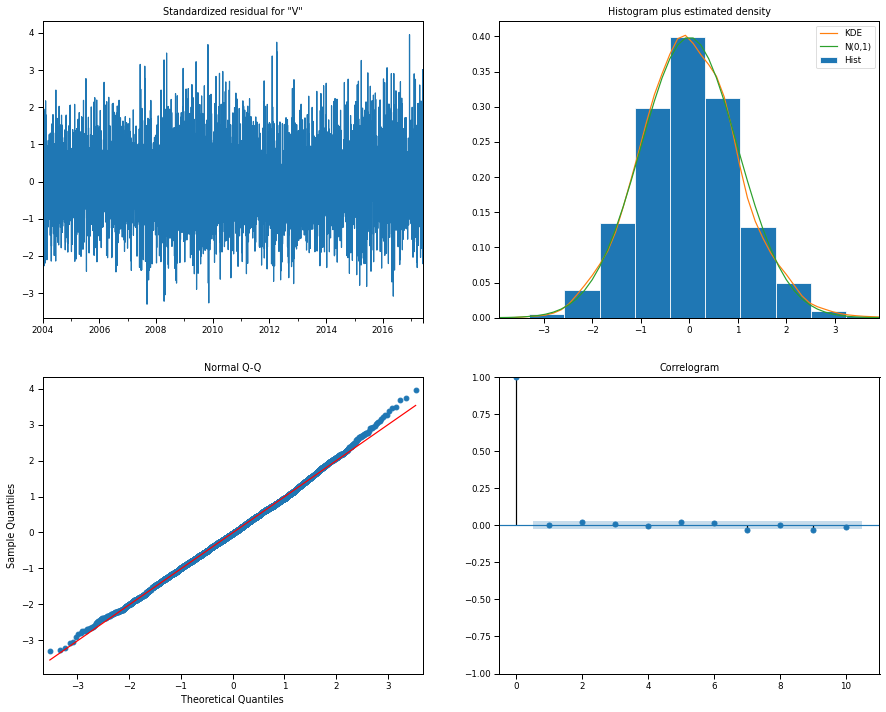

In [ ]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

> PLOT

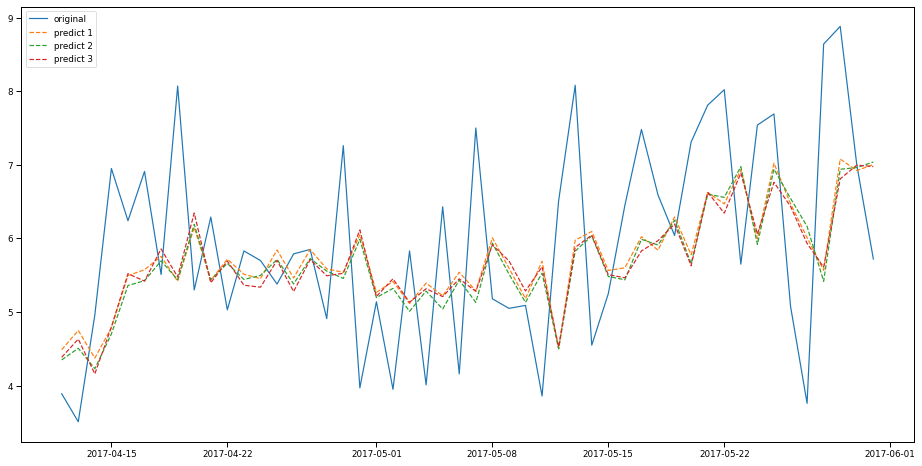

In [ ]:
fig = plt.subplots(figsize=(16,8))
plt.plot(df_vento.Velocidade[4850:], label='original')
plt.plot(model_fit.predict(4850),'--',label='predict 1')
plt.plot(model_fit2.predict(4850),'--',label='predict 2')
plt.plot(model_fit3.predict(4850),'--',label='predict 3')
plt.legend()